In [1]:
import tonic
from tonic import SlicedDataset
from tonic.slicers import SliceByTime, SliceByEventCount
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [2]:
nmnist = tonic.datasets.NMNIST("data/", train=False)
cifar10dvs = tonic.datasets.CIFAR10DVS("data/")
# events, label = cifar10dvs[0]

# transform = tonic.transforms.ToImage(
#     sensor_size=cifar10dvs.sensor_size,
# )

# image = transform(events[:10000])

# plt.imshow(image[0])# - image[0])
# plt.axis(False)
# plt.show()

In [5]:
dataset = nmnist

In [7]:
from multiprocessing import Pool

transforms = [
    tonic.transforms.Denoise(filter_time=1200),
    tonic.transforms.ToFrame(
        sensor_size=nmnist.sensor_size,
        event_count=20000,
        overlap=15000,
    ),
]

nmnist_transform = tonic.transforms.Compose(transforms) # type: ignore

cifar_transforms = [
    tonic.transforms.Denoise(filter_time=1200),
    tonic.transforms.ToFrame(
        sensor_size=cifar10dvs.sensor_size,
        event_count=20000,
        overlap=15000,
    ),
]
cifar_transform = tonic.transforms.Compose(cifar_transforms) # type: ignore

In [13]:
dataset = [
    (events, label) for events, label in tqdm(dataset, desc="Loading data")
]

Loading data: 100%|██████████| 10000/10000 [00:04<00:00, 2367.65it/s]


In [22]:
dataset2 = [(events, label) for events, label in tqdm(dataset, desc="Transforming data")]

Transforming data: 100%|██████████| 10000/10000 [00:00<00:00, 379194.11it/s]


In [26]:
# transform the data using asyncio and multiprocessing
def processor(i):
    events, label = dataset[i]
    return transform(events), label

with Pool(8) as p:
    transformed_dataset = p.map(processor, range(len(dataset)))

In [23]:
type(transformed_dataset)

list

In [25]:
import pandas as pd
labels = [label for events, label in transformed_dataset]
pd.Series(labels).value_counts().sort_index()

0    980
1     20
Name: count, dtype: int64

In [3]:
cifar10dvs

CIFAR10DVS

In [5]:
cifar_dataset = [
    cifar10dvs[i] for i in tqdm(range(1000), desc="Loading CIFAR10DVS data")
]

Loading CIFAR10DVS data: 100%|██████████| 1000/1000 [00:06<00:00, 156.45it/s]


In [9]:
def f(i):
    events, label = cifar10dvs[i]
    frames = cifar_transform(events)
    return frames, label

with Pool(12) as p:
    results = list(
        tqdm(
            p.imap(
                f,
                range(200),
                chunksize=4,
            ),
            total=200,
        )
    )
    

100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


In [27]:
x = torch.concat([torch.from_numpy(r[0]) for r in results])
y = torch.tensor([r[1] for r in results])

In [28]:
x.shape

torch.Size([3041, 2, 128, 128])

(24, 2, 128, 128)


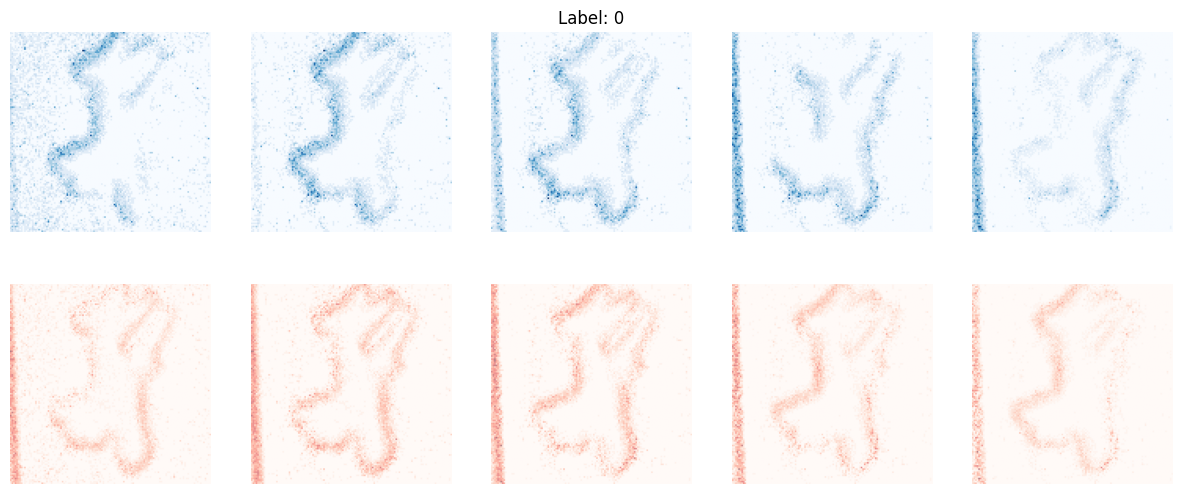

In [9]:
events, label = cifar10dvs[2]

transform = tonic.transforms.Compose(
    [
        tonic.transforms.Denoise(filter_time=5000),
        tonic.transforms.ToFrame(
            sensor_size=cifar10dvs.sensor_size,
            event_count=20000,
            overlap=15000,
        ),
    ]
)

frames = transform(events)

print(frames.shape)  # (num_frames, H, W)

# plot the first 5 frames as columns with positive events in blue and negative events in red
fig, axes = plt.subplots(2, min(5, frames.shape[0]), figsize=(15, 6))
for i in range(min(5, frames.shape[0])):
    if i == 2:
        axes[0, i].set_title(f"Label: {label}")
    axes[0, i].imshow(frames[i, 0], cmap="Blues") # positive events
    axes[1, i].imshow(frames[i, 1], cmap="Reds", alpha=0.5) # negative events
    axes[0, i].axis(False)
    axes[1, i].axis(False)
plt.show()

In [6]:

slicer = tonic.slicers.SliceByEventCount(event_count=1000, overlap=500)
slice_transform = tonic.transforms.Compose(
    [
        tonic.transforms.Denoise(filter_time=800),
        tonic.transforms.ToImage(sensor_size=nmnist.sensor_size),
    ]
)
sliced_dataset = SlicedDataset(nmnist, slicer) #, transform=slice_transform)


KeyboardInterrupt: 

Label: 3
Frames shape: (2, 34, 34)
Label: 0
Frames shape: (2, 34, 34)
Label: 2
Frames shape: (2, 34, 34)
Label: 2
Frames shape: (2, 34, 34)
Label: 1
Frames shape: (2, 34, 34)


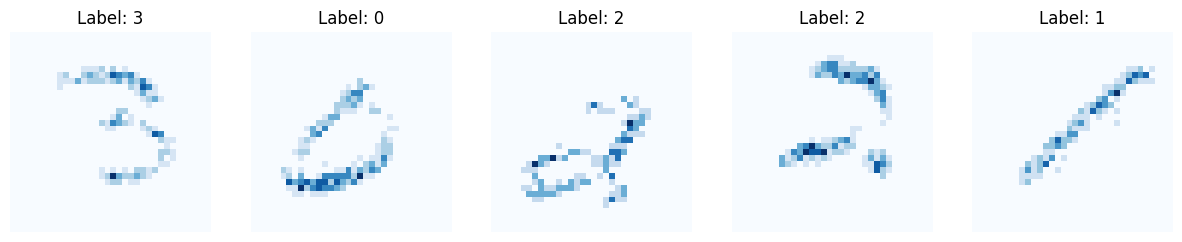

In [ ]:
sampled_frames_and_labels = [
    (sliced_dataset[i][0], sliced_dataset[i][1]) for i in np.random.choice(len(sliced_dataset), size=5)
]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (frames, label) in enumerate(sampled_frames_and_labels):
    print(f"Label: {label}")
    print(f"Frames shape: {frames.shape}")  # (num_frames, H, W)
    axes[i].imshow(frames[0], cmap="Blues")  # Show the first frame
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label}")

plt.show()

In [ ]:
class SlicedDatasetWithTransform(torch.utils.data.Dataset):
    """A wrapper around tonic.SlicedDataset to apply transforms and move to device."""
    def __init__(self, dataset, transform=None, device=None, **kwargs):
        self.dataset = dataset
        assert transform is not None, "Transform must be provided"
        self.transform = transform
        self.device = device

    def __getitem__(self, index):
        events, label = self.dataset[index]
        frame = self.transform(events)
        # torchify
        frame = torch.from_numpy(frame).float()
        label = torch.tensor(label).long()

        if self.device:
            frame = frame.to(self.device)
            label = label.to(self.device)
        return frame, label
    
    def __len__(self):
        return len(self.dataset)

dataset = SlicedDatasetWithTransform(
    sliced_dataset, transform=slice_transform, device="cpu"
)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=10
)

processed_batches = 0
for batch_frames, batch_labels in tqdm(dataloader):
    print(f"Batch frames shape: {batch_frames.shape}")  # (B, num_frames, H, W)
    print(f"Batch labels shape: {batch_labels.shape}. Labels: {batch_labels}")  # (B,)
    print(f"Unique labels in batch: {batch_labels.unique()}")
    # Check the type, device and data type
    print(f"Batch frames type: {type(batch_frames)}, device: {batch_frames.device}, dtype: {batch_frames.dtype}")
    print(f"Batch labels type: {type(batch_labels)}, device: {batch_labels.device}, dtype: {batch_labels.dtype}")
    if processed_batches >= 0:
        break
    else:
        processed_batches += 1

  0%|          | 0/12834 [00:00<?, ?it/s]

Batch frames shape: torch.Size([32, 2, 34, 34])
Batch labels shape: torch.Size([32]). Labels: tensor([7, 4, 0, 3, 7, 8, 4, 3, 6, 2, 3, 0, 2, 2, 2, 1, 4, 8, 0, 0, 0, 3, 0, 8,
        3, 4, 5, 5, 9, 6, 9, 9])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Batch frames type: <class 'torch.Tensor'>, device: cpu, dtype: torch.float32
Batch labels type: <class 'torch.Tensor'>, device: cpu, dtype: torch.int64


  0%|          | 0/12834 [00:02<?, ?it/s]


In [ ]:
slicing_time_window = 100_000  # microseconds
slicer = SliceByTime(time_window=slicing_time_window)
frame_transform = tonic.transforms.ToImage(
    sensor_size=tonic.datasets.CIFAR10DVS.sensor_size
)

sliced_dataset = SlicedDataset(
    cifar10dvs, slicer=slicer, transform=frame_transform,# metadata_path="./metadata/cifar10dvs"
)

print(f"Number of samples in the sliced dataset: {len(sliced_dataset)}")

Number of samples in the sliced dataset: 124462


In [ ]:
frames, targets = sliced_dataset[103]


In [ ]:
(frames > 0).sum()

np.int64(7685)

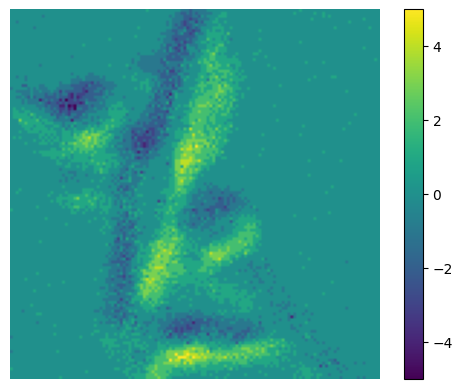

In [ ]:
image = frames[1] - frames[0]
# image = (frames[1] + frames[0]) > 1

plt.imshow(image)
plt.axis(False)
plt.colorbar()
plt.show()